<a href="https://colab.research.google.com/github/abuzarmahmood/pymcon_bayesian_changepoint/blob/master/Bayesian_Changepoint_Zoo_neural_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Execute only if executing in Google Colab
if IN_COLAB:
    !pip install --upgrade pip
    !pip install --upgrade pymc==5.9.0 numpyro==0.13.2
    !git clone https://github.com/abuzarmahmood/pymcon_bayesian_changepoint.git
    !mv pymcon_bayesian_changepoint/src .
    !mv pymcon_bayesian_changepoint/data .

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import pymc as pm
import pylab as plt
from scipy import stats
import pytensor.tensor as tt
#import aesara.tensor as tt
import multiprocessing
from scipy.stats import pearsonr, poisson
import seaborn as sns

In [4]:
from src import get_data, gen_plots

# ==== Prelude ====

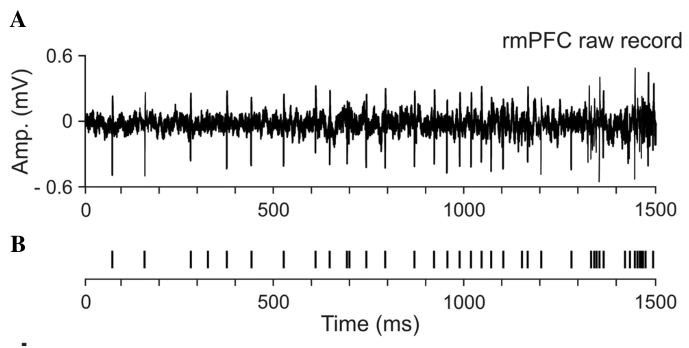

**REF**: Fig. 2, Caro-Martín, C.R., Delgado-García, J.M., Gruart, A. et al. Spike sorting based on shape, phase, and distribution features, and K-TOPS clustering with validity and error indices. Sci Rep 8, 17796 (2018). https://doi.org/10.1038/s41598-018-35491-4

- If you record voltage from the brain, neurons show sharp "spikes" in their activity when they are active/on (**panel A**)
- Many neurons display reliable patterns of activity in response to an event or stimulus (e.g. sugar water on the tongue, or seeing a specific object).
- To visualize these patterns of activity, we can denote the times at which the neuron is active in a "spike train" (**panel B**). This is a timeseries of binary values indicating when the neuron was active.
- Analyzing the dynamics of the spike trains can inform us about which brain regions are active for a specific process (e.g. processing taste), and at what times.

# ==== Load Data ====

- We will load data from an extracellular recording from the Gustatory Cortex (see **REF** below) involving 30 repeated deliveries of a single taste (30 trials), 7 simultanesouly recorded neurons, and 4000ms of spike trains following taste delivery, binned into 100ms binned (therefore, a total of 40 timebins).

- **REF**: Katz, D. B., et al. “Dynamic and Multimodal Responses of Gustatory Cortical Neurons in Awake Rats.” The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, vol. 21, no. 12, June 2001, pp. 4478–89. PubMed, https://doi.org/10.1523/JNEUROSCI.21-12-04478.2001.

In [5]:
# Binned spike trains (spike counts)
spike_dat = np.load(os.path.join('data/binned_spikes.npy'))

In [6]:
print(f'{spike_dat.shape} = (Trials, Neurons, Time)')

(30, 7, 40) = (Trials, Neurons, Time)


In [7]:
# Sum spikes along trials to use for single-trial examples
sum_spikes = spike_dat.sum(axis=0)

In [8]:
print(f'{sum_spikes.shape} = (Neurons, Time)')

(7, 40) = (Neurons, Time)


## Visualize data

Plot spike-trains and firing rates for some neurons

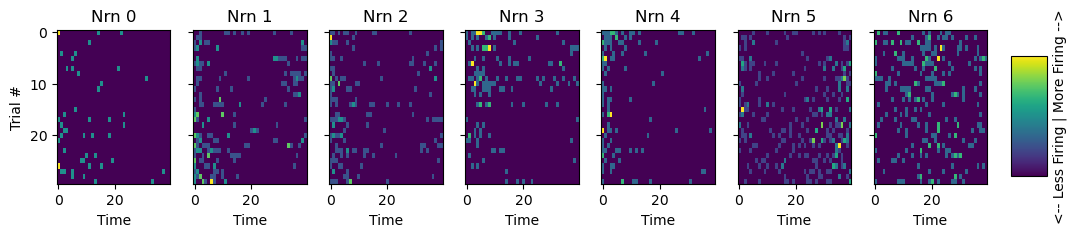

In [9]:
img_kwargs = dict(interpolation = 'nearest', aspect = 'auto')

fig,ax = plt.subplots(1, 
                      spike_dat.shape[1], 
                      figsize = (12,2), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_dat,0,1), ax.flatten())):
    im = this_ax.imshow(this_dat, **img_kwargs)
    this_ax.set_title(f'Nrn {ind}');
    this_ax.set_xlabel('Time');
ax[0].set_ylabel('Trial #');
cax = fig.add_axes([0.92, 0.15, 0.03, 0.6])
cbar = fig.colorbar(im, cax=cax, label = '<-- Less Firing | More Firing -->')
cbar.set_ticks([])

# === Poisson Multivariate Changepoint ===

- We first analyze spike-trains using a Poisson multi-changepoint model to see when changes occur.
- We will infer when changes in the neural activity happen on-average, summing spikes across trials.

Parent example: </br>
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb

## Get, and plot data

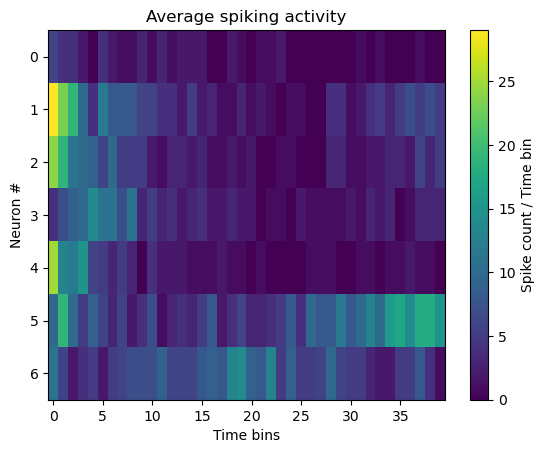

In [8]:
plt.imshow(sum_spikes, **img_kwargs);
plt.xlabel('Time bins');
plt.ylabel('Neuron #');
plt.title('Average spiking activity');
plt.colorbar(label = 'Spike count / Time bin');

## Construct simple Poisson Model

In [47]:
n_nrn, n_time_bins = sum_spikes.shape
n_states = 3 # Selected based on domain knowledge
idx = np.arange(n_time_bins)

# Generate emission initvals
mean_firing = np.stack(
    [x.mean(axis=-1) \
     for x in np.array_split(sum_spikes, n_states, axis=-1)]
).T
# Add 0.1 to avoid any zeros
mean_firing += 0.1

with pm.Model() as simple_model:

    # Latent Emissions
    # ===================
    # Rate for Poisson process (positive + continuous)
    lambda_latent = pm.Exponential('lambda_latent', 
                                   0.1,
                                   initval=mean_firing,
                                   shape = (n_nrn, n_states))

    # Changepoint position
    # =====================
    # We want a distribution that is 1) continuous, 2) models values on an interval
    # Beta distribution is a good candidate for these specifications
    # tau_latent = pm.Beta(
    #     'tau_latent', 1, 1,
    #     initval = np.linspace(0,1,n_states+1)[1:-1],
    #     shape = (n_states-1),
    # ).sort(axis=-1)

    tau_latent = pm.Dirichlet('tau_latent', [1,1,1],
                             shape = (n_states),
                             )

    # We then scale the "tau_latent" from a 0-->1 interval to the length of the data
    tau = pm.Deterministic('tau',
            idx.min() + (idx.max() - idx.min()) * tt.cumsum(tau_latent)[:-1],
            )

    # Calculating changing emission rates over time
    # ==============================================
    # The likelihood will expect a rate for every datapoint
    # Therefore, we must use the emission and changepoint variables to construct our inferred rate
    # We will use sigmoids to generate "temporal states" (see link below) 
    
    # For visual example of how multiplying sigmoids results in "states"
    # see: https://www.desmos.com/calculator/yisbydv2cq
    
    # We need to know the timecourse of states determined by "tau"
    # We will call this the "weight_stack"
    # See plots below for visualization of generating the "weight_stack"
    
    forward_stack = tt.math.sigmoid(
        idx[np.newaxis, :]-tau[:, np.newaxis])
    forward_stack = tt.concatenate(
        [np.ones((1, n_time_bins)), forward_stack], axis=0)

    inverse_stack = 1 - forward_stack[1:]
    inverse_stack = tt.concatenate(
        [inverse_stack, np.ones((1, n_time_bins))], axis=0)

    weight_stack = np.multiply(forward_stack, inverse_stack)

    # Now that we've generated the "weight_stack", we need to populate
    # each state with it's emission rate using lambda_latent
    # Hence, we need a dot-product over the "state" dimension of each variable
    lambda_ = tt.tensordot(     
        lambda_latent,  # neurons x states
        weight_stack, # states x time
        axes = (1,0)
    )

    # Likelihood
    # =====================
    observation = pm.Poisson("obs", lambda_, observed=sum_spikes)

Text(0.5, 0, 'Time Bin')

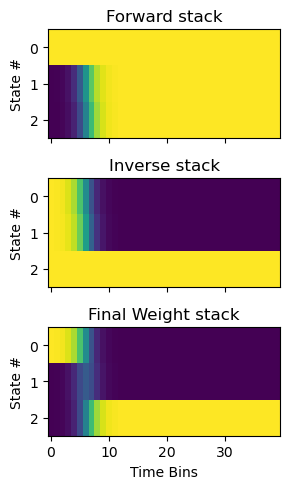

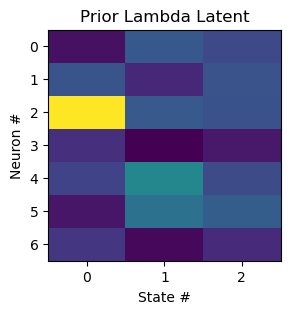

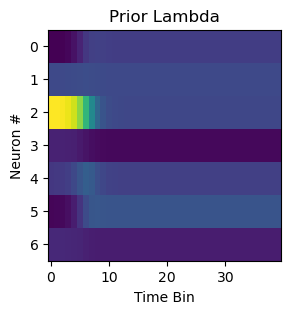

In [48]:
fig,ax = plt.subplots(3,1, sharex=True, figsize = (3,5))
ax[0].imshow(forward_stack.eval(), **img_kwargs)
ax[0].set_title('Forward stack')


ax[1].imshow(inverse_stack.eval(), **img_kwargs)
ax[1].set_title('Inverse stack')


ax[2].imshow(weight_stack.eval(), **img_kwargs)
ax[2].set_title('Final Weight stack')
for this_ax in ax:
    this_ax.set_ylabel('State #')
ax[-1].set_xlabel('Time Bins')
plt.tight_layout()

plt.figure(figsize= (3,3))
plt.imshow(lambda_latent.eval(), **img_kwargs);
plt.title('Prior Lambda Latent')
plt.xlabel('State #')
plt.ylabel('Neuron #')

plt.figure(figsize= (3,3))
plt.imshow(lambda_.eval(), **img_kwargs);
plt.title('Prior Lambda')
plt.ylabel('Neuron #')
plt.xlabel('Time Bin')

**Check prior over `lambda_latent` to make sure we're in the right range**

Sampling: [lambda_latent, obs, tau_latent]


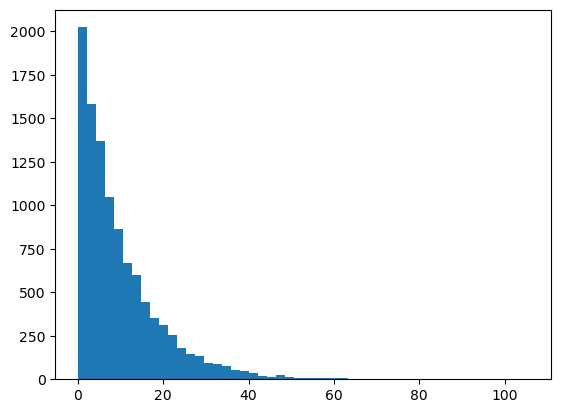

In [49]:
with simple_model:
    prior_pred = pm.sample_prior_predictive()

lambda_prior = prior_pred['prior']['lambda_latent'].values
plt.hist(lambda_prior.flatten(), 50);

**Result of sorting beta variables for `tau`**

Text(0, 0.5, 'Tau 2')

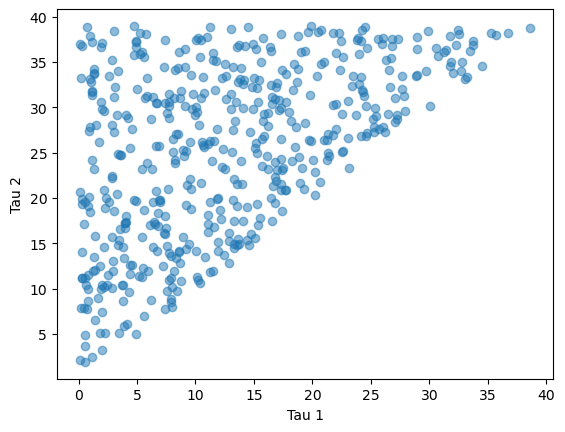

In [50]:
plt.scatter(*np.squeeze(prior_pred['prior']['tau']).T, alpha = 0.5)
plt.xlabel('Tau 1')
plt.ylabel('Tau 2')

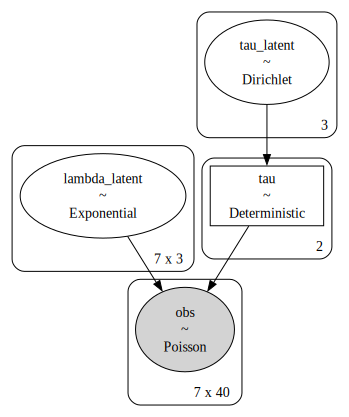

In [51]:
# Plot the graph for the model
pm.model_to_graphviz(simple_model)

## Perform Inference

In [52]:
# Run inference on the model
with simple_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_latent, tau_latent]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


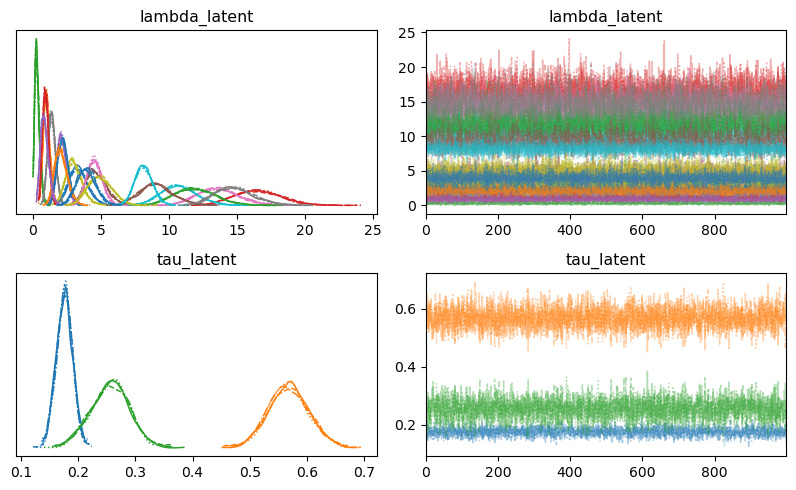

In [53]:
# Plot inferred distributions
ax = pm.plot_trace(trace, figsize = (8,5), var_names = ['lambda_latent','tau_latent']);
plt.tight_layout()

## Analyze Results

In [54]:
# Sample from posterior
with simple_model:
    poisson_ppc = pm.sample_posterior_predictive(trace)

Sampling: [obs]


Generate plots of:
1) Actual data with inferred changepoints overlayed
2) Posterior predictive observations
3) Distribution of changepoint positions
4) Inferred lambda_latent (Emission Rates)

Text(0.5, 0, 'Time')

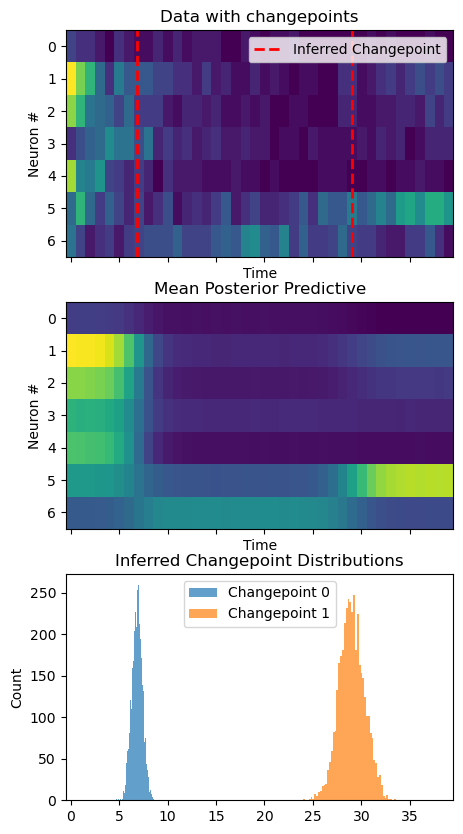

In [56]:
figsize = (5,10)
years = idx

# Mean data from posterior
ppc_values = poisson_ppc['posterior_predictive']['obs']
mean_ppc, std_ppc = np.mean(ppc_values,axis=(0,1)),np.std(ppc_values,axis=(0,1))

# Inferred changepoiont positions
poisson_switch_inferred = trace["posterior"]["tau"].values

mean_switch = poisson_switch_inferred.mean(axis=(0,1)) 
std_switch = poisson_switch_inferred.std(axis=(0,1))

# Generate plots
fig, ax = plt.subplots(3,1,figsize=figsize, sharex=True)
ax[0].imshow(sum_spikes,aspect='auto')
ax[0].set_ylabel("Neuron #") 
ax[0].set_xlabel("Time") 
ax[0].set_title('Data with changepoints')

for num, this_val in enumerate(mean_switch):
    if num == 0:
        ax[0].axvline(this_val,
                   color="red", linewidth = 2, 
                      linestyle = '--', label = 'Inferred Changepoint')
    else:
        ax[0].axvline(this_val,
                   color="red", linewidth = 2, 
                      linestyle = '--',)
ax[0].legend()

ax[1].imshow(mean_ppc, aspect='auto')
ax[1].set_title('Mean Posterior Predictive')
ax[1].set_ylabel("Neuron #") 
ax[1].set_xlabel("Time") 

for num, change in enumerate(poisson_switch_inferred.T):
    ax[2].hist(change.flatten(), 
               bins = 50, alpha = 0.7,
              label = f'Changepoint {num}')
ax[2].legend()
ax[2].set_title('Inferred Changepoint Distributions')
ax[2].set_ylabel("Count") 
ax[1].set_xlabel("Time") 

Text(0.5, 1.0, 'Inferred Emissions (lambda_latent)')

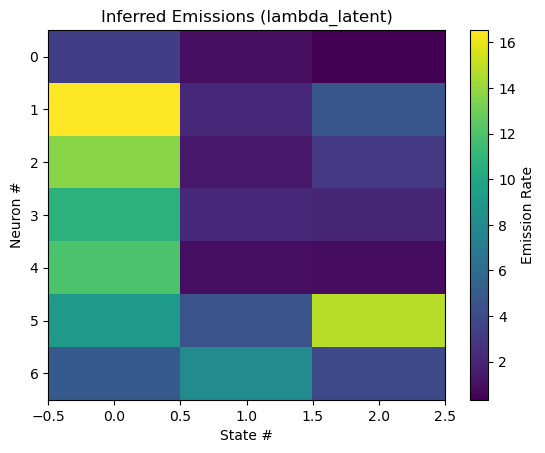

In [57]:
# Extract and plot inferred emission rates (lambda_latent)
lambda_latent_inferred = trace["posterior"]["lambda_latent"].values
mean_lambda_latent = lambda_latent_inferred.mean(axis=(0,1))

plt.imshow(mean_lambda_latent, aspect='auto');
plt.colorbar(label = 'Emission Rate')
plt.xlabel('State #')
plt.ylabel('Neuron #')
plt.title('Inferred Emissions (lambda_latent)')

# === Dirichlet Process Changepoint ===

- In the above example, we set the number of state/changepoints as a fixed parameter
- But what about cases where we don't know the number of changepoints
- One method is to use model comparison metrics (see Fig. 4 in **REF 1** below). However, it is difficult to interpret differences between these values from one model to the next
- A potentially more interpretable way is to place a prior over the number of components.
- Here we employ a Dirichlet Process prior over the number of states (for more details, see **REF 2** and **Related Reading**)
- **Note-1**: The Dirichlet Process returns state lengths, however, we can treat cumulative state lengths as transition times.

- **REF**:
  1) Mahmood, Abuzar, et al. “Coupled Dynamics of Stimulus-Evoked Gustatory Cortical and Basolateral Amygdalar Activity.” Journal of Neuroscience, vol. 43, no. 3, Jan. 2023, pp. 386–404. www.jneurosci.org, https://doi.org/10.1523/JNEUROSCI.1412-22.2022.
  2) https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/mixture_models/dp_mix.html
- **Related Reading**: https://medium.com/@abuzar_mahmood/probabilistically-determining-the-number-of-components-for-unsupervised-learning-e1c3c4a82082

In [88]:
# Select noisier data for training
dpp_dat = spike_dat[:7].sum(axis=0)

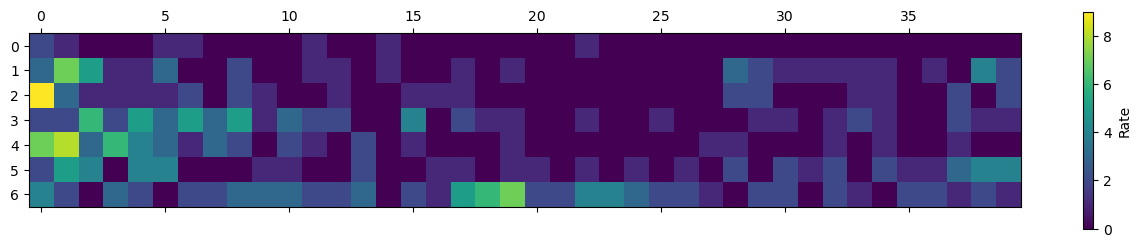

In [89]:
plt.matshow(dpp_dat)
plt.colorbar(label = 'Rate')

## Define Model

**Dirichlet Process -- Stick Breaking Construction**

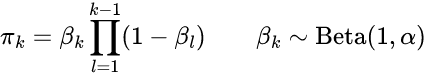

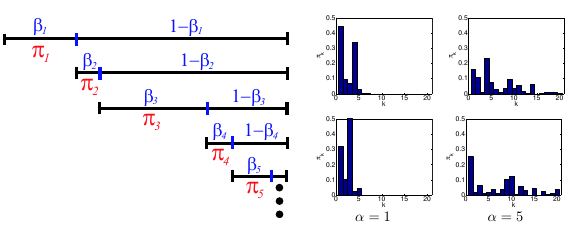

**Fig. 12** -- Wiecki, Thomas V. Sequential Sampling Models in Computational Psychiatry: Bayesian Parameter Estimation, Model Selection and Classification. arXiv, 22 Mar. 2013. arXiv.org, https://doi.org/10.48550/arXiv.1303.5616.

**Note-2**: The Stick-Breaking representation of the Dirichlet Process does not explicitly model state counts...instead, it simply tries to fit the "appropriate" number of states. Hence, some thresholding will be required to convert the inferred state durations into state counts.

In [90]:
def stick_breaking(beta):
    portion_remaining = pm.math.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [407]:
# Index vector timebins in data
n_nrn, n_time_bins = dpp_dat.shape
idx = np.arange(n_time_bins)
max_states = 10

with pm.Model() as dpp_model:

    # ===================
    # Emissions Variables
    # ===================
    # Exponential prior on Poisson rate
    lambda_latent = pm.Exponential('lambda',
                    0.1,
                    shape = (n_nrn, max_states))

    # =====================
    # Changepoint Variables
    # =====================
    # Each timeseries is divided into chunks (states) using a 
    # Dirichlet Process, here instantiated using a Stick-Breaking Process

    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', mu = 10, sigma = 4)

    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = max_states)

    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))

    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    # Changepoint locations cumulatively summed state lenghts
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * n_time_bins)[:-1])

    # Calculating changing emission rates over time
    # ==============================================
    # The likelihood will expect a rate for every datapoint
    # Therefore, we must use the emission and changepoint variables to construct our inferred rate
    # We will use sigmoids to generate "temporal states" (see link below) 
    
    # For visual example of how multiplying sigmoids results in "states"
    # see: https://www.desmos.com/calculator/yisbydv2cq
    
    # We need to know the timecourse of states determined by "tau"
    # We will call this the "weight_stack"
    # See plots below for visualization of generating the "weight_stack"
    weight_stack = pm.math.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = pm.math.concatenate([np.ones((1,n_time_bins)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = pm.math.concatenate([inverse_stack, np.ones((1,n_time_bins))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    # Create timeseries for latent variable (mean emission)
    lambda_ = pm.Deterministic('lambda_',
                               tt.tensordot(
                                   lambda_latent, # neurons x states
                                   weight_stack, # states x timebins
                                   axes=(1,0)
                               )
                              )

    # Likelihood
    # =====================
    observation = pm.Poisson("obs", lambda_, observed=dpp_dat)

In [408]:
with dpp_model:
    prior_trace = pm.sample_prior_predictive()

Sampling: [alpha, beta, lambda, obs]


Text(0.5, 1.0, 'w_latent cumsum plot')

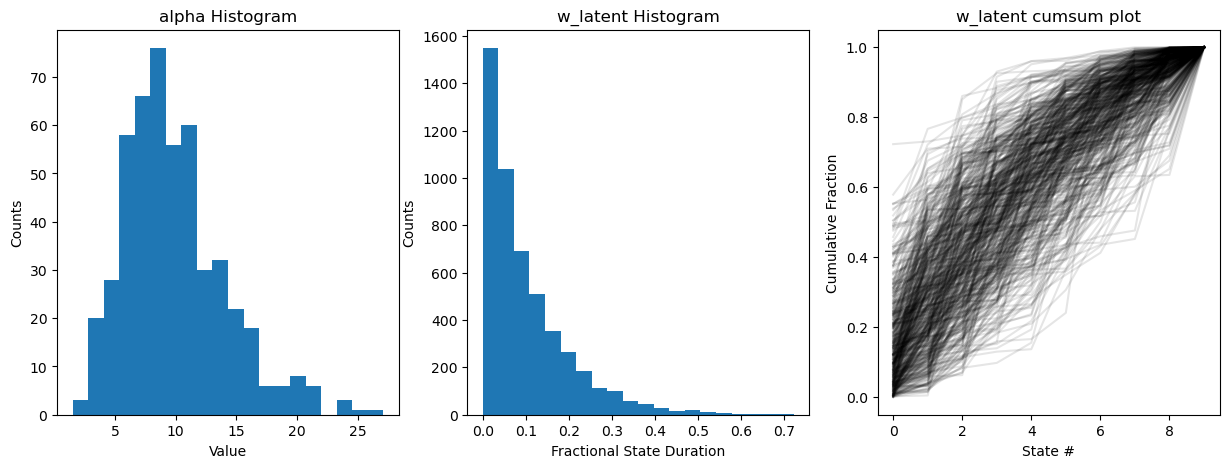

In [409]:
fig,ax = plt.subplots(1,3, figsize = (15,5))
ax[0].hist(np.squeeze(prior_trace['prior']['alpha'].values), bins = 20);
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Value')
ax[0].set_title('alpha Histogram')

w_latent_prior = np.squeeze(prior_trace['prior']['w_latent'].values)
ax[1].hist(w_latent_prior.flatten(), bins = 20);
ax[1].set_xlabel('Fractional State Duration')
ax[1].set_ylabel('Counts')
ax[1].set_title('w_latent Histogram')

ax[2].plot(np.cumsum(w_latent_prior, axis=-1).T, color = 'k', alpha = 0.1);
ax[2].set_xlabel('State #')
ax[2].set_ylabel('Cumulative Fraction')
ax[2].set_title('w_latent cumsum plot')

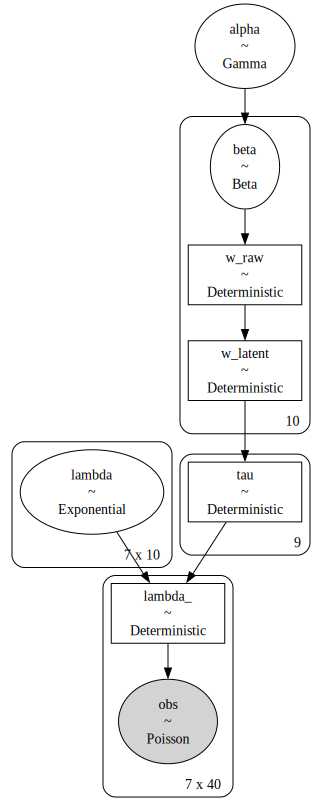

In [410]:
pm.model_to_graphviz(dpp_model)

## Perform Inference

In [ ]:
# Sampler tends to get stuck, therefore we use many chains
# An alternative would be to use Sequential Monte Carlo sampling
n_chains = 50
n_samples = 10000
samples_per_chain = n_samples // n_chains

with dpp_model:
    dpp_trace = pm.sample(
                        nuts_sampler="numpyro",
                        tune = samples_per_chain,
                        draws = samples_per_chain,
                        target_accept = 0.95,
                        chains = n_chains,
                        cores = multiprocessing.cpu_count()
                        )

## Analyze Results

Make plots for:
1) Inferred state durations
2) Raw Data
3) Changepoint locations
4) Number of states after thresholding

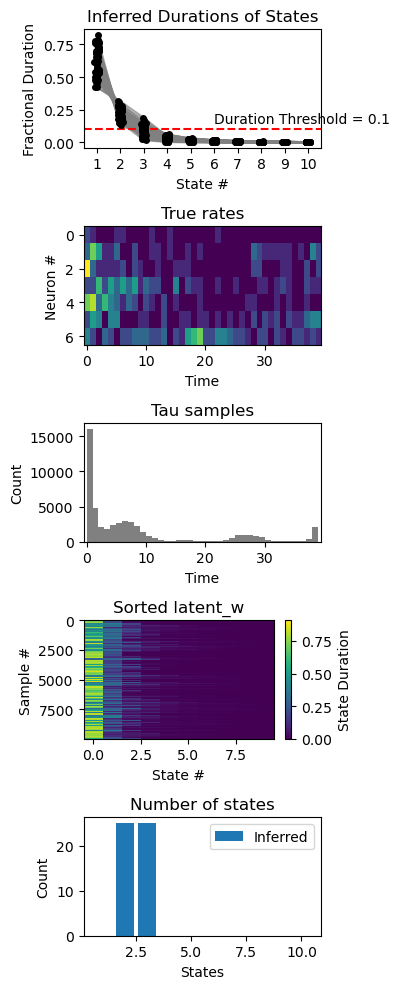

In [415]:
gen_plots.gen_dirichlet_plots(dpp_trace, dpp_dat, n_chains, n_time_bins, max_states, 
                              n_states = None, dur_thresh = 0.1, figsize = (4,10))

**The above analysis asssumes a fixed threshold. However, we can see how stable this inference is across thresholds.**

In [416]:
mean_w_latent = dpp_trace['posterior']['w_latent'].values.mean(axis=1)
thresh_vec = np.linspace(0.01, 0.2)

state_bins = np.arange(10)+0.5
thresh_counts = []
for this_thresh in thresh_vec:
    this_counts = (mean_w_latent > this_thresh).sum(axis=-1)
    thresh_counts.append(this_counts)

median_counts = np.array([np.median(x) for x in thresh_counts])
count_frame = pd.concat([pd.DataFrame(data = dict(thresh = this_thresh, counts = this_count)) \
                        for this_thresh, this_count in zip(thresh_vec, thresh_counts)])

Text(0.5, 1.0, '2D Histogram across thresholds')

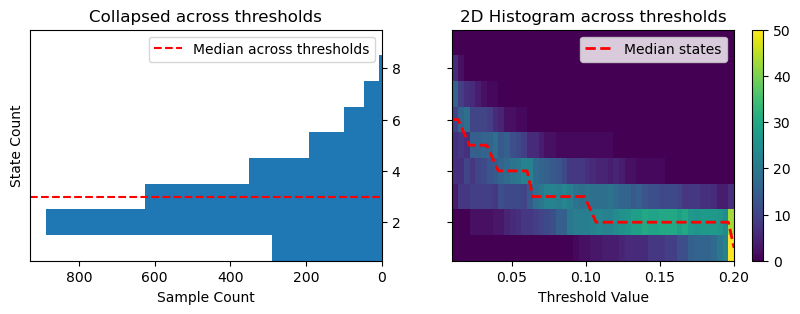

In [417]:
fig, ax = plt.subplots(1,2, sharey=True, figsize = (10,3))
im = ax[1].hist2d(*count_frame.values.T, bins = [thresh_vec, state_bins]);
ax[1].plot(thresh_vec, median_counts, color = 'red', linestyle = '--', linewidth = 2, label = "Median states");
ax[1].set_xlabel('Threshold Value');
ax[0].set_ylabel('State Count');
ax[0].set_xlabel('Sample Count');
ax[1].legend()
plt.colorbar(im[3], ax=ax[1])
ax[0].hist(count_frame['counts'], bins = state_bins, orientation = 'horizontal');
ax[0].set_xlim(ax[0].get_xlim()[::-1])
ax[0].yaxis.tick_right()
ax[0].axhline(np.median(count_frame['counts']), color = 'red', linestyle = '--', label = 'Median across thresholds');
ax[0].legend();

ax[0].set_title('Collapsed across thresholds')
ax[1].set_title('2D Histogram across thresholds')

# === Mixture Emissions Changepoint ===

- Averaging across trials (as we have done above) assumes that the data do not drift. While this is true in most cases, in many cases, data for all trials DO NOT come from the same distribution (see **REF** below).
- In such cases, we need to account for this inhomogeneity and treat these sets of trials differently, else, our model will likely perform poorly (see what happens when we fail to account for inhomogeneity in the **Related Reading** below).
- This would be easy if we knew which trials were different, but in many cases, we don't have any a-priori knowledge about this.
- Hence, a principled way to address this issue is to use a changepoint model which allows changes in emissions.
- One such model would be one with a mixture of emissions.
- **Note**: In the model below, we assume that the changepoint positions do not drift.

- **REF** : Humphries, Mark D. “Spike-Train Communities: Finding Groups of Similar Spike Trains.” Journal of Neuroscience, vol. 31, no. 6, Feb. 2011, pp. 2321–36. www.jneurosci.org, https://doi.org/10.1523/JNEUROSCI.2853-10.2011.
- **Related Reading**: https://medium.com/@abuzar_mahmood/changepoint-detection-for-inhomogeneous-timeseries-mixture-emissions-in-pymc3-2301f76c0064

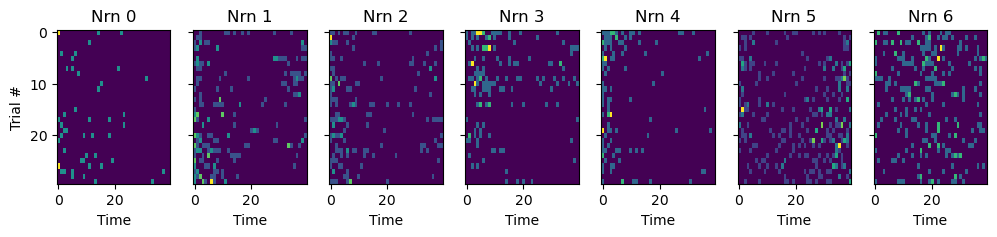

In [91]:
fig,ax = plt.subplots(1, 
                      spike_dat.shape[1], 
                      figsize = (12,2), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_dat,0,1), ax.flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(f'Nrn {ind}');
    this_ax.set_xlabel('Time');
ax[0].set_ylabel('Trial #');

- In the plots above, we can see changes across both time, and across trials.
- **Roughly, trials after #15 exhibit different emission rates than those before.**
- This means that if we fit a changepoint model for multiple trials, we can not assume constant emissions.

**Dirichlet Distribution**

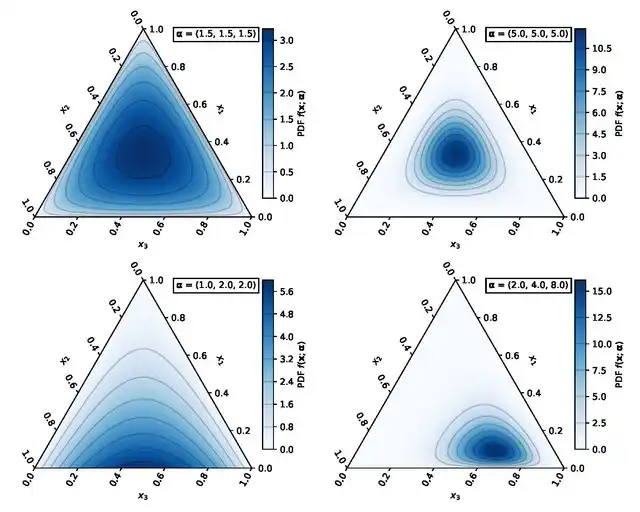

## Define Model

In [14]:
n_trials, nrn_num, time_bins = spike_dat.shape
n_components = 2 # Number of components in the mixture
n_states = 3 # Number of states across time (per trial)


# Generate initvals for emission rates
# ======================================
# Average across sets of trials
mean_firing = np.stack(
    np.array_split(spike_dat, n_components, axis=0)).mean(axis=1)
# Average across time
mean_firing = np.array_split(mean_firing, n_states, axis=2)
mean_firing = np.stack([x.mean(axis=-1) for x in mean_firing])
# Add 0.1 to avoid any zeros
mean_firing += 0.1


with pm.Model() as model:

    # Mixture Weights
    # ===================
    # We will define this as a marginalized mixture, such that we
    # are not categorically assigning observations to clusters
    # See for similar example: 
    # https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/mixture_models/marginalized_gaussian_mixture_model.html
    
    # A Dirichlet distribution (which has finite dimensions, hence not to be
    # confused with the "infinite" Dirichlet Process above) provides
    # us weights that sum to 1.
    
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    # trials x n_components
    w = pm.Dirichlet('w', a=alpha_w, shape = (n_trials,n_components))

    # Latent Emissions
    # ===================
    # Emissions are hierachically defined to reduce independence 
    # The idea being that all activity of a single neuron is more similar 
    # to itself than to acticity of other neurons (nrn_lambda --> trial_lambda).
    # Similarly, the activity of a single neuron on a single trial is more
    # similar to itself than to activity of the same neuron on a different trial
    # (trial_lambda --> state_lambda).
    
    # nrns
    nrn_lambda = pm.Exponential('nrn_lambda', 100, shape=(nrn_num))

    # nrns x switch_comps
    comp_lambda = pm.Exponential('comp_lambda',
                                  nrn_lambda.dimshuffle(0, 'x'),
                                  shape=(nrn_num, n_components))

    # nrns x n_components x n_states
    state_lambda = pm.Exponential('state_lambda',
                                  comp_lambda.dimshuffle(0, 1, 'x'),
                                  initval = mean_firing.T,
                                  shape=(nrn_num, n_components, n_states))

    # Changepoint position
    # =====================
    # Assuming distribution of changepoints remains
    # the same across all trials

    a = pm.HalfCauchy('a_tau', 3., shape=n_states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape=n_states - 1)

    tau_latent = pm.Beta('tau_latent', a, b,
                         shape=(n_trials, n_states-1))

    # # Trials x Changepoints
    tau = pm.Deterministic('tau', time_bins * tau_latent)

    # Calculating changing emission rates over time
    # ==============================================

    idx = np.arange(time_bins)

    # tau : Trials x Changepoints
    weight_stack = pm.math.sigmoid(
        idx[np.newaxis, :]-tau[:, :, np.newaxis])
    weight_stack = tt.concatenate(
        [np.ones((n_trials, 1, time_bins)), weight_stack], axis=1)
    inverse_stack = 1 - weight_stack[:, 1:]
    inverse_stack = tt.concatenate(
        [inverse_stack, np.ones((n_trials, 1, time_bins))], axis=1)

    # Trials x n_states x Time
    weight_stack = np.multiply(weight_stack, inverse_stack)

    # Calculate mixing of emission components
    # ==============================================
    # Multiply mixture weights with mixture values
    
    # Trials x neurons x n_states
    selected_lambdas = pm.Deterministic(
        'selected_lambdas', 
        tt.math.tensordot(w,  # trials x components
                          state_lambda, # neurons x components x states
                          axes=(1,1)))

    # Calculate rates across time
    # ==============================================
    # trials x neurons x time
    lambda_ = tt.sum(
        # trials x n_states x neurons x None        # trials x n_states x None x time
        selected_lambdas.dimshuffle(0, 2, 1, 'x') * weight_stack.dimshuffle(0, 1, 'x', 2),
                             # trials x n_states x neurons x time
                     axis=1)

    # Likelihood
    # =====================
    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=spike_dat)

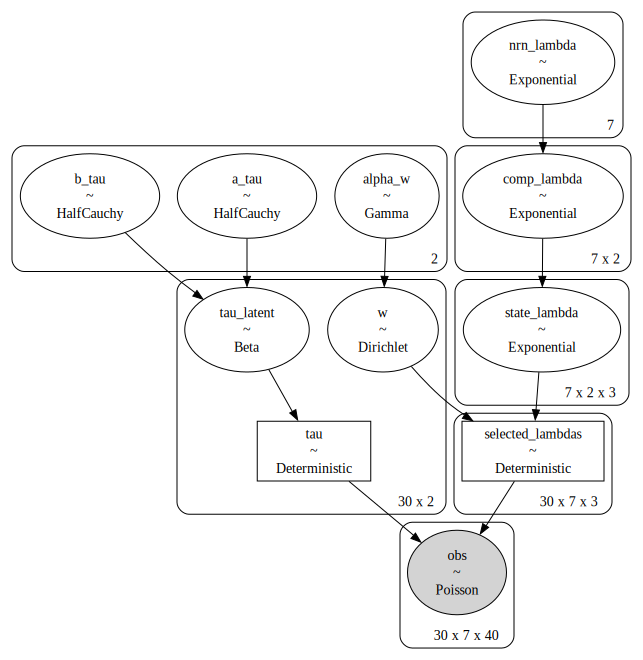

In [15]:
pm.model_to_graphviz(model)

## Perform Inference

In [ ]:
with model:
    trace = pm.sample(nuts_sampler="numpyro", chains = 4, cores = 4)

## Analyze Results

Generate plots for:
1) Mixture weights across trials
2) State_lambda (latent emissions) across trials
3) Z-scored state_lambda (latent emissions) across trials (to highlight changes)
4) Changepoint positions across trials
5) Comparing actual data to mean posterior predictive

In [444]:
selected_lambdas_post = trace['posterior']['selected_lambdas'].values
w_post = trace['posterior']['w'].values

mean_selected_lambdas = selected_lambdas_post.mean(axis=(0,1))
mean_w = w_post.mean(axis=(1))

nrn_mean_lambdas = np.swapaxes(mean_selected_lambdas, 0,1)

Text(0, 0.5, 'Weight Value')

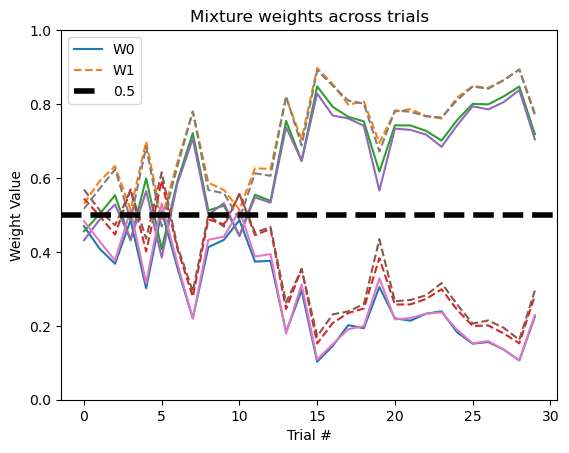

In [445]:
for ind, chain in enumerate(mean_w):
    if ind == 0:
        labels = ['W0','W1']
    else:
        labels = [None, None]
    plt.plot(chain[:,0], label = labels[0])
    plt.plot(chain[:,1], linestyle = '--', label = labels[1])
plt.ylim(0,1)
plt.axhline(0.5, linestyle = '--', label = '0.5', color = 'k', linewidth = 4)
plt.legend()
plt.title('Mixture weights across trials')
plt.xlabel('Trial #')
plt.ylabel('Weight Value')

Text(1.05, 0.25, 'Z-Scored')

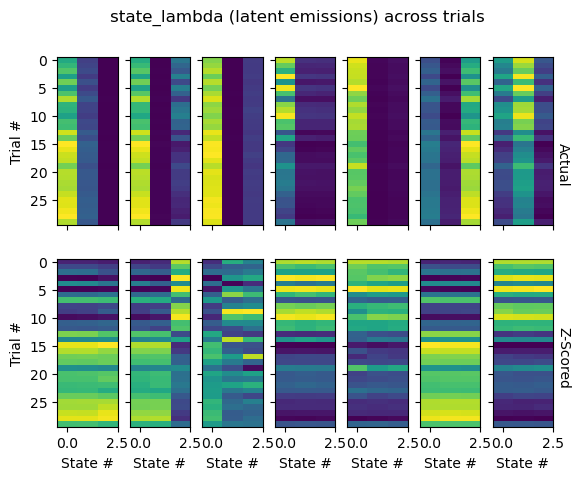

In [437]:
fig, ax = plt.subplots(2, len(nrn_mean_lambdas), sharex=True, sharey=True)
for this_ax, this_dat in zip(ax[0], nrn_mean_lambdas):
    this_ax.imshow(this_dat, aspect='auto')
fig.suptitle('state_lambda (latent emissions) across trials')

for this_ax, this_dat in zip(ax[1], nrn_mean_lambdas):
    this_ax.imshow(stats.zscore(this_dat,axis=0), aspect='auto')
    this_ax.set_xlabel('State #')

ax[0,0].set_ylabel('Trial #')
ax[1,0].set_ylabel('Trial #')
fig.suptitle('state_lambda (latent emissions) across trials')

ax[0,-1].text(1.05, 0.25, 'Actual', rotation = 270, transform=ax[0,-1].transAxes)
ax[1,-1].text(1.05, 0.25, 'Z-Scored', rotation = 270, transform=ax[1,-1].transAxes)

In [295]:
tau_stack = trace['posterior']['tau'].values
int_tau = np.vectorize(int)(tau_stack)
mode_tau = np.squeeze(stats.mode(int_tau,axis=(0,1))[0])

Text(0.5, 1.0, 'Changepoint positions across trials')

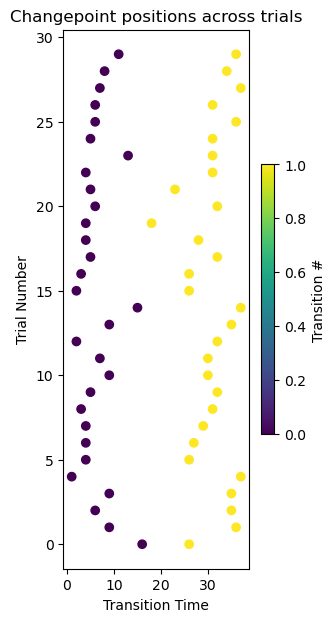

In [315]:
fig,ax = plt.subplots(figsize = (3,7))
for num, vals in enumerate(mode_tau):
    im = ax.scatter(vals,[num]*len(vals), c = range(len(vals)))
plt.colorbar(im, shrink = 0.5, label = 'Transition #')
plt.xlabel('Transition Time')
plt.ylabel('Trial Number')
plt.title('Changepoint positions across trials')

**Inspect Posterior Predictive**

In [298]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)

Sampling: [obs]


In [306]:
ppc_obs = ppc_trace['posterior_predictive']['obs'].values
mean_ppc_obs = ppc_obs.mean(axis=(0,1))

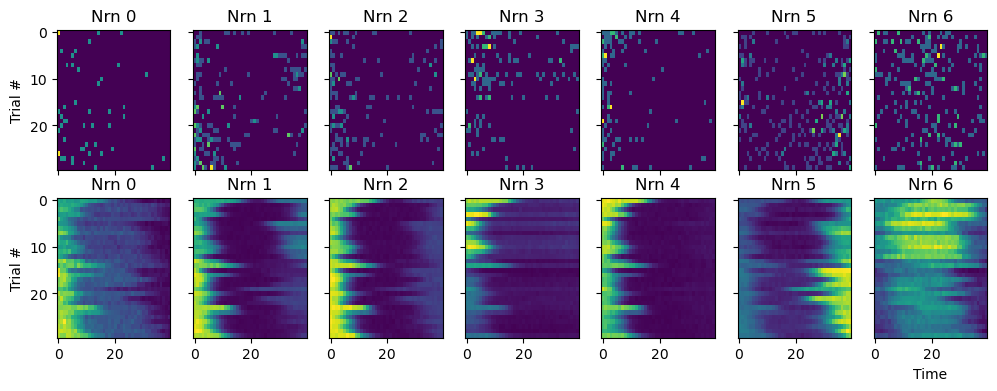

In [308]:
fig,ax = plt.subplots(2, 
                      spike_dat.shape[1], 
                      figsize = (12,4), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_dat,0,1), ax[0].flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(f'Nrn {ind}');
    if ind==0:
        this_ax.set_ylabel('Trial #');
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(mean_ppc_obs,0,1), ax[1].flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(f'Nrn {ind}');
    if ind==0:
        this_ax.set_ylabel('Trial #');
this_ax.set_xlabel('Time');

# === Acknowledgements ===

I am deeply grateful to **Dr. Donald Katz** for supporting this work, to **Dr. Narendra Mukherjee** for introducing me to Bayesian modelling, and to the funding sources below:

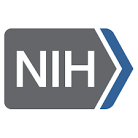

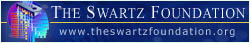

These models were created using open-source code shared by **PyMC Developers and Users**.

Special thanks to **PyMCon Organizers** for the opportunity, and especially **Ravin Kumar** and **Purna Chandra Mansingh** for advice and coordination.

# === Trial-Switch Mixture Emissions Changepoint ===

In [18]:
n_switch_components = 2 # Number of components in the mixture
n_states = 3 # Number of states across time (per trial)

trial_num, nrn_num, time_bins = spike_dat.shape

with pm.Model() as model:

    # Define Emissions

    # nrns
    nrn_lambda = pm.Exponential('nrn_lambda', 10, shape=(nrn_num))

    # nrns x switch_comps
    trial_lambda = pm.Exponential('trial_lambda',
                                  nrn_lambda.dimshuffle(0, 'x'),
                                  shape=(nrn_num, n_switch_components))

    # nrns x switch_comps x states
    state_lambda = pm.Exponential('state_lambda',
                                  trial_lambda.dimshuffle(0, 1, 'x'),
                                  shape=(nrn_num, n_switch_components, n_states))

    # Define Changepoints
    # Assuming distribution of changepoints remains
    # the same across all trials

    a = pm.HalfCauchy('a_tau', 3., shape=n_states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape=n_states - 1)

    even_switches = np.linspace(0, 1, n_states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b,
                         #initval=even_switches[None,:],
                         shape=(trial_num, n_states-1)).sort(axis=-1)

    # Trials x Changepoints
    tau = pm.Deterministic('tau', time_bins * tau_latent)

    # Define trial switches
    # Will have same structure as regular changepoints

    even_trial_switches = np.linspace(0, 1, n_switch_components+1)[1:-1]
    tau_trial_latent = pm.Beta('tau_trial_latent', 1, 1,
                               #testval=even_trial_switches,
                               shape=(n_switch_components-1)).sort(axis=-1)

    # Trial_changepoints
    tau_trial = pm.Deterministic('tau_trial', trial_num * tau_trial_latent)

    trial_idx = np.arange(trial_num)
    trial_selector = tt.math.sigmoid(
        trial_idx[np.newaxis, :] - tau_trial.dimshuffle(0, 'x'))

    trial_selector = tt.concatenate(
        [np.ones((1, trial_num)), trial_selector], axis=0)
    inverse_trial_selector = 1 - trial_selector[1:, :]
    inverse_trial_selector = tt.concatenate([inverse_trial_selector,
                                            np.ones((1, trial_num))], axis=0)

    # First, we can "select" sets of emissions depending on trial_changepoints
    # switch_comps x trials
    trial_selector = np.multiply(trial_selector, inverse_trial_selector)

    # state_lambda: nrns x switch_comps x states

    # selected_trial_lambda : nrns x states x trials
    selected_trial_lambda = pm.Deterministic('selected_trial_lambda',
                                             tt.sum(
                                                 # "nrns" x switch_comps x "states" x trials
                                                 trial_selector.dimshuffle(
                                                     'x', 0, 'x', 1) * state_lambda.dimshuffle(0, 1, 2, 'x'),
                                                 axis=1)
                                             )

    # Then, we can select state_emissions for every trial
    idx = np.arange(time_bins)

    # tau : Trials x Changepoints
    weight_stack = tt.math.sigmoid(
        idx[np.newaxis, :]-tau[:, :, np.newaxis])
    weight_stack = tt.concatenate(
        [np.ones((trial_num, 1, time_bins)), weight_stack], axis=1)
    inverse_stack = 1 - weight_stack[:, 1:]
    inverse_stack = tt.concatenate(
        [inverse_stack, np.ones((trial_num, 1, time_bins))], axis=1)

    # Trials x states x Time
    weight_stack = np.multiply(weight_stack, inverse_stack)

    # Convert selected_trial_lambda : nrns x trials x states x "time"

    # nrns x trials x time
    lambda_ = tt.sum(selected_trial_lambda.dimshuffle(0, 2, 1, 'x') * weight_stack.dimshuffle('x', 0, 1, 2),
                     axis=2)

    # Convert to : trials x nrns x time
    lambda_ = lambda_.dimshuffle(1, 0, 2)

    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=spike_dat)

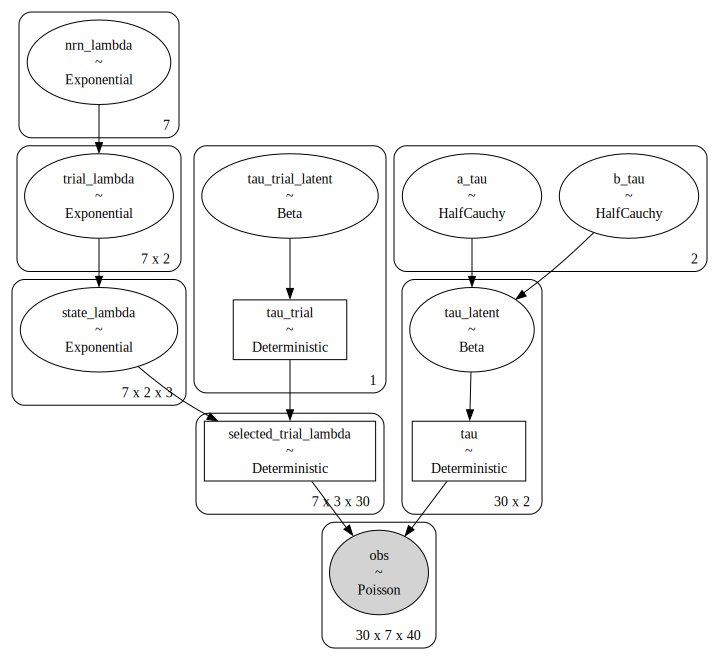

In [19]:
pm.model_to_graphviz(model)

In [46]:
# # Sampler tends to get stuck, therefore we use many chains
# # An alternative would be to use Sequential Monte Carlo sampling
# n_chains = 50
# n_samples = 10000
# samples_per_chain = n_samples // n_chains

# with model:
#     trace = pm.sample(
#             nuts_sampler="numpyro",
#             tune = samples_per_chain,
#             draws = samples_per_chain,
#             target_accept = 0.95,
#             chains = n_chains,
#             cores = multiprocessing.cpu_count()
#             )

In [47]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=200000, method=inference)
    trace = approx.sample(draws=20000)

Interrupted at 7,504 [7%]: Average Loss = 3,745


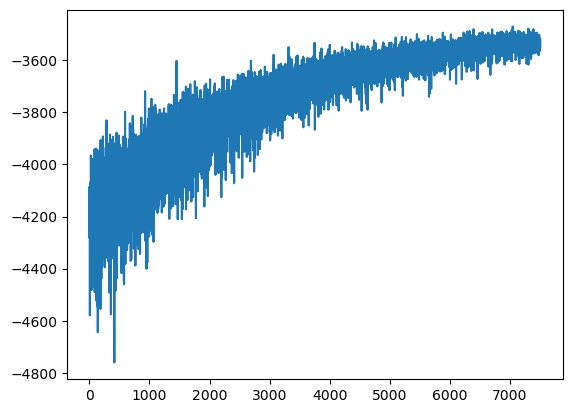

In [48]:
plt.plot(-approx.hist)

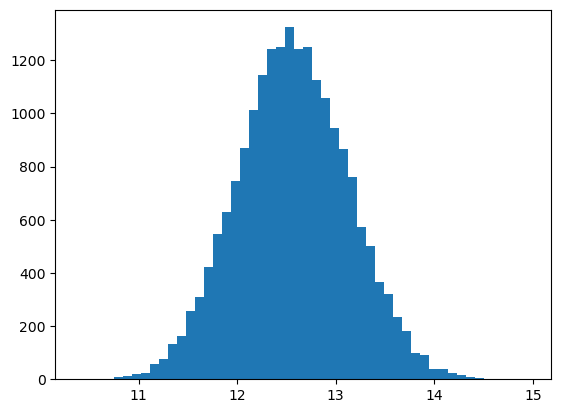

In [30]:
plt.hist(trace.posterior.tau_trial.values.flatten(), bins = 50);

# === Dirichlet Process Trial-Switch Mixture Emissions Changepoint ===

In [14]:
def stick_breaking(beta):
    portion_remaining = pm.math.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [15]:
mean_rate = spike_dat.mean(axis=(0,2))
mean_rate

array([2.89      , 3.90833333, 4.0475    , 3.63166667, 3.4625    ,
       3.22      , 3.235     ])

In [16]:
max_rate = spike_dat.max(axis=None)
max_rate

16

In [17]:
n_switch_components = 5 # Number of components in the mixture
n_states = 3 # Number of states across time (per trial)

trial_num, nrn_num, time_bins = spike_dat.shape



with pm.Model() as model:

    # Define Emissions

    # nrns
    #nrn_lambda = pm.Exponential('nrn_lambda', 1/mean_rate, shape=(nrn_num))
    nrn_lambda = pm.Uniform('nrn_lambda', np.zeros(nrn_num), np.ones(nrn_num)*max_rate*2, shape=(nrn_num))

    # nrns x switch_comps
    trial_lambda = pm.Exponential('trial_lambda',
                                  1/nrn_lambda.dimshuffle(0, 'x'),
                                  shape=(nrn_num, n_switch_components))

    # nrns x switch_comps x states
    state_lambda = pm.Exponential('state_lambda',
                                  1/trial_lambda.dimshuffle(0, 1, 'x'),
                                  shape=(nrn_num, n_switch_components, n_states))

    # Define Changepoints
    # Assuming distribution of changepoints remains
    # the same across all trials

    a_tau = pm.HalfCauchy('a_tau', 3., shape=n_states)

    tau_latent = pm.Dirichlet('tau_latent', a_tau,
                         shape = (trial_num, n_states),
                         )

    # Trials x Changepoints
    # We then scale the "tau_latent" from a 0-->1 interval to the length of the data
    tau = pm.Deterministic('tau',
            time_bins * tt.cumsum(tau_latent, axis=-1)[:,:-1],
            )

    # =====================
    # Changepoint Variables
    # =====================
    # Each timeseries is divided into chunks (states) using a 
    # Dirichlet Process, here instantiated using a Stick-Breaking Process

    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', mu = 10, sigma = 4)

    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = n_switch_components)

    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))

    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    # Changepoint locations cumulatively summed state lenghts
    tau_trial = pm.Deterministic('tau_trial', tt.cumsum(w_latent * trial_num)[:-1])

    ######################################################

    # # Define trial switches
    # # Will have same structure as regular changepoints

    # even_trial_switches = np.linspace(0, 1, n_switch_components+1)[1:-1]
    # tau_trial_latent = pm.Beta('tau_trial_latent', 1, 1,
    #                            #testval=even_trial_switches,
    #                            shape=(n_switch_components-1)).sort(axis=-1)

    # # Trial_changepoints
    # tau_trial = pm.Deterministic('tau_trial', trial_num * tau_trial_latent)

    #########################################################

    trial_idx = np.arange(trial_num)
    trial_selector = tt.math.sigmoid(
        trial_idx[np.newaxis, :] - tau_trial.dimshuffle(0, 'x'))

    trial_selector = tt.concatenate(
        [np.ones((1, trial_num)), trial_selector], axis=0)
    inverse_trial_selector = 1 - trial_selector[1:, :]
    inverse_trial_selector = tt.concatenate([inverse_trial_selector,
                                            np.ones((1, trial_num))], axis=0)

    # First, we can "select" sets of emissions depending on trial_changepoints
    # switch_comps x trials
    trial_selector = np.multiply(trial_selector, inverse_trial_selector)

    # state_lambda: nrns x switch_comps x states

    # selected_trial_lambda : nrns x states x trials
    selected_trial_lambda = pm.Deterministic('selected_trial_lambda',
                                             tt.sum(
                                                 # "nrns" x switch_comps x "states" x trials
                                                 trial_selector.dimshuffle(
                                                     'x', 0, 'x', 1) * state_lambda.dimshuffle(0, 1, 2, 'x'),
                                                 axis=1)
                                             )

    # Then, we can select state_emissions for every trial
    idx = np.arange(time_bins)

    # tau : Trials x Changepoints
    weight_stack = tt.math.sigmoid(
        idx[np.newaxis, :]-tau[:, :, np.newaxis])
    weight_stack = tt.concatenate(
        [np.ones((trial_num, 1, time_bins)), weight_stack], axis=1)
    inverse_stack = 1 - weight_stack[:, 1:]
    inverse_stack = tt.concatenate(
        [inverse_stack, np.ones((trial_num, 1, time_bins))], axis=1)

    # Trials x states x Time
    weight_stack = np.multiply(weight_stack, inverse_stack)

    # Convert selected_trial_lambda : nrns x trials x states x "time"

    # nrns x trials x time
    lambda_ = tt.sum(selected_trial_lambda.dimshuffle(0, 2, 1, 'x') * weight_stack.dimshuffle('x', 0, 1, 2),
                     axis=2)

    # Convert to : trials x nrns x time
    lambda_ = lambda_.dimshuffle(1, 0, 2)

    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=spike_dat)

In [18]:
with model:
    idata = pm.sample_prior_predictive()

Sampling: [a_tau, alpha, beta, nrn_lambda, obs, state_lambda, tau_latent, trial_lambda]


In [19]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

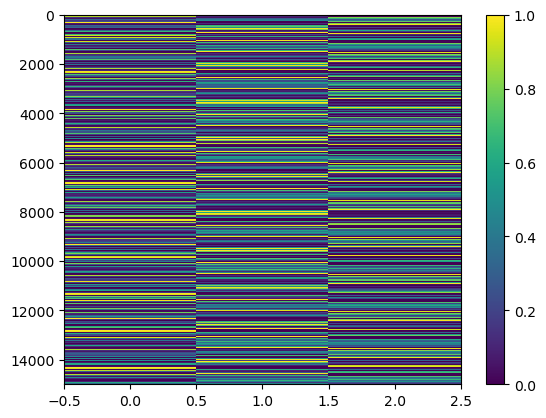

In [20]:
tau_latent_prior = idata.prior.tau_latent.stack(sample = ('chain', 'draw')).values
tau_latent_prior = np.concatenate(np.swapaxes(tau_latent_prior, 1,2))
plt.imshow(tau_latent_prior, aspect='auto', interpolation='none');
plt.colorbar()

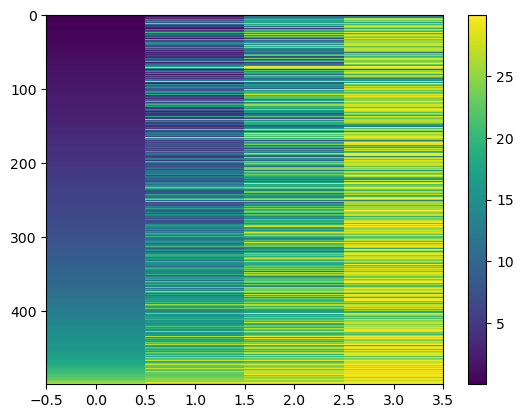

In [21]:
tau_trial_prior = idata.prior.tau_trial.stack(sample = ('chain', 'draw')).values
tau_trial_prior.shape
sort_inds = np.argsort(tau_trial_prior[0])
plt.imshow(tau_trial_prior.T[sort_inds], aspect='auto', interpolation='none');
plt.colorbar()

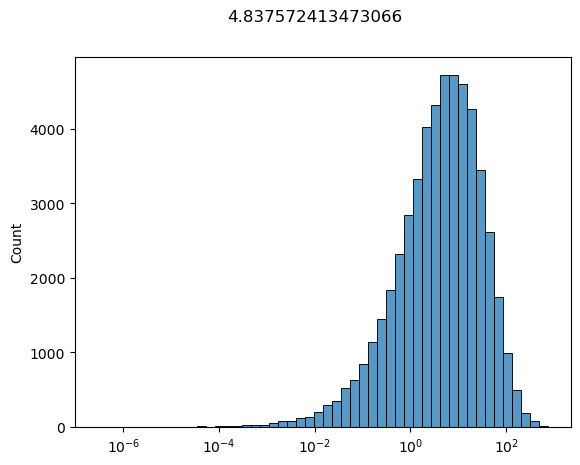

In [22]:
state_lambda_prior = idata.prior.state_lambda.stack(sample = ('chain', 'draw')).values
state_lambda_prior.shape
sns.histplot(state_lambda_prior.flatten(), bins = 50, log_scale=True);
sns.histplot(spike_dat.flatten(), bins = 50, log_scale=True);
plt.suptitle(np.median(state_lambda_prior.flatten()));

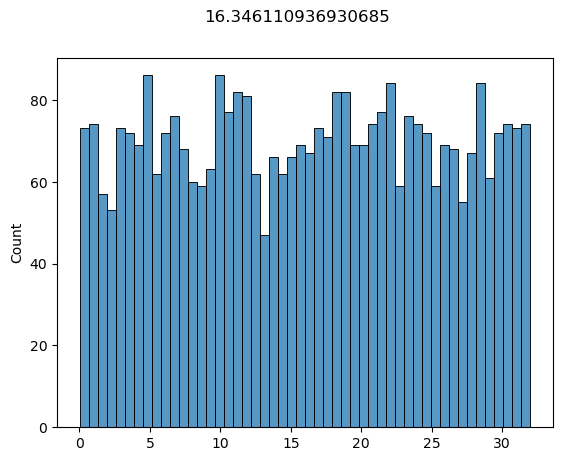

In [23]:
nrn_lambda_prior = idata.prior.nrn_lambda.stack(sample = ('chain', 'draw')).values
state_lambda_prior.shape
sns.histplot(nrn_lambda_prior.flatten(), bins = 50);
plt.suptitle(np.median(nrn_lambda_prior.flatten()));

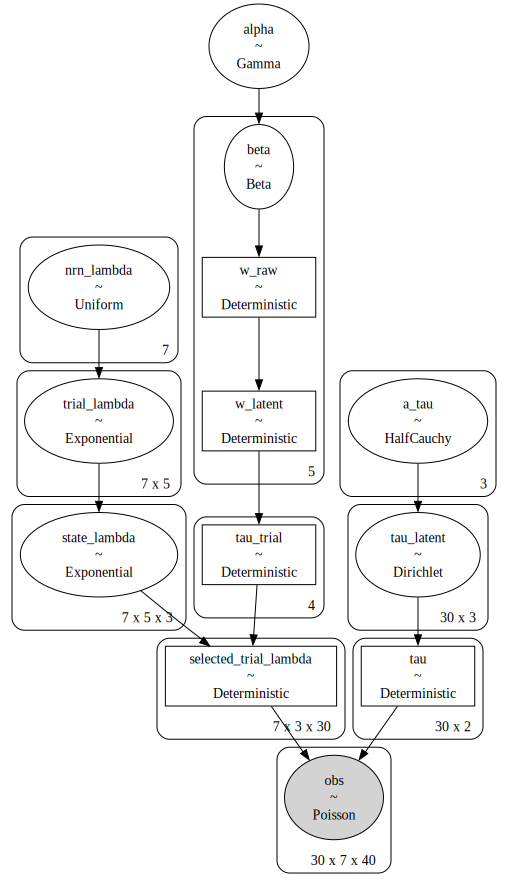

In [24]:
pm.model_to_graphviz(model)

In [25]:
# Sampler tends to get stuck, therefore we use many chains
# An alternative would be to use Sequential Monte Carlo sampling
n_chains = 25
n_samples = 5000
samples_per_chain = n_samples // n_chains

with model:
    mcmc_trace = pm.sample(
            nuts_sampler="numpyro",
            tune = samples_per_chain,
            draws = samples_per_chain,
            # target_accept = 0.95,
            chains = n_chains,
            cores = np.min([multiprocessing.cpu_count(), n_chains])
            )

Only 200 samples in chain.
/home/abuzarmahmood/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:24.571827
Sampling...


Compiling.. :   0%|                                                                                                                                         | 0/400 [00:00<?, ?it/s]

  0%|                                                                                                                                                       | 0/400 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                                                         | 0/400 [00:00<?, ?it/s]


  0%|                                                                                                                                                       | 0/400 [00:00<?, ?it/s]


Compiling.. :   0%|                                                                                                                                         | 0/400 [00:00<?, ?it/s]



  0%|                                                                                 

Sampling time =  0:13:45.411128
Transforming variables...
Transformation time =  0:00:01.016654


In [26]:
# with model:
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=200000, method=inference)
#     advi_trace = approx.sample(draws=20000)

# plt.plot(-approx.hist)

In [27]:
trace = mcmc_trace;

In [28]:
post_tau_trial = trace.posterior.tau_trial.values
post_tau_trial_cat = np.concatenate(post_tau_trial)

In [29]:
post_tau_trial.shape

(25, 200, 4)

In [30]:
spike_dat.shape

(30, 7, 40)

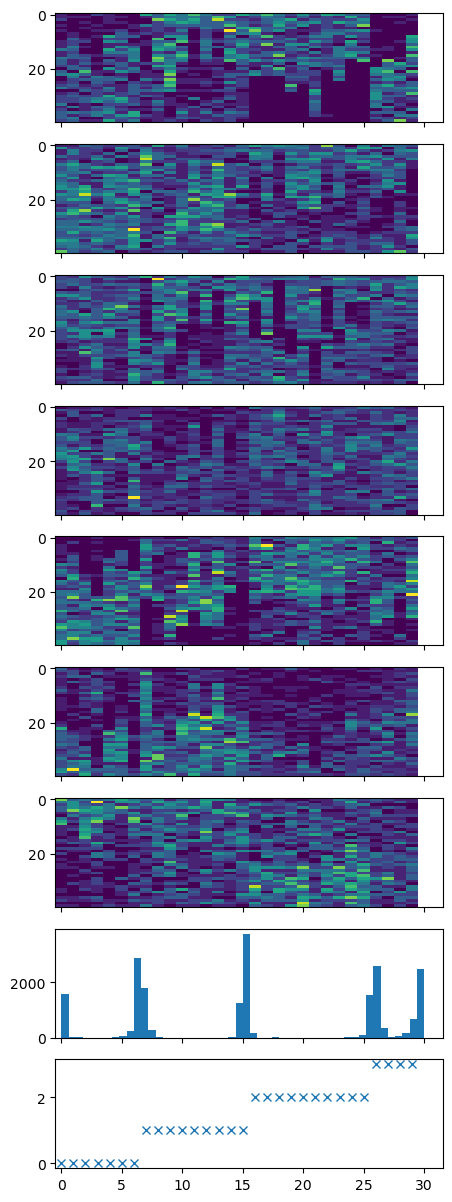

In [53]:
fig, ax = plt.subplots(spike_dat.shape[1] + 2, 1, figsize = (5,15), sharex=True)
for i in range(len(ax)-2):
    ax[i].imshow(spike_dat[:,i].T, interpolation = 'nearest', aspect = 'auto')
ax[-2].hist(post_tau_trial.flatten(), bins = 50);
ax[-1].plot(component_inds,'x')
# for x in post_tau_trial.T:
#     ax[-1].hist(x, bins = 50)

In [32]:
post_w_raw = trace.posterior.w_raw.values
post_w_raw_sorted = np.sort(post_w_raw, axis=-1)[...,::-1]
post_w_raw_cat = np.concatenate(post_w_raw_sorted)
post_w_raw.shape

(25, 200, 5)

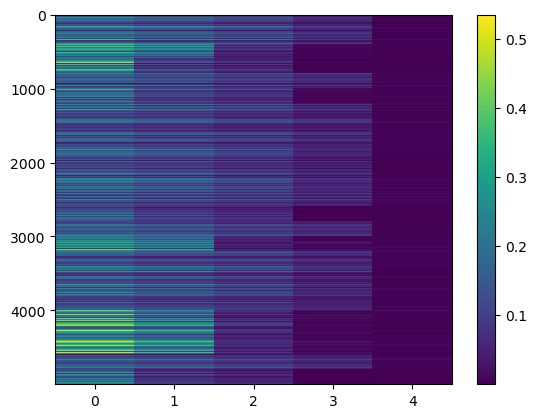

In [33]:
plt.imshow(post_w_raw_cat, aspect='auto', interpolation='none')
plt.colorbar()

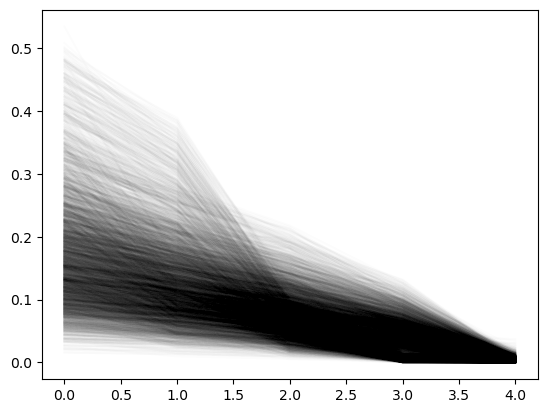

In [34]:
mean_post_w_raw = np.mean(post_w_raw_sorted, axis=1)
plt.plot(post_w_raw_cat.T, color = 'k', alpha = 0.01);

In [35]:
inds = np.array(list(np.ndindex(post_w_raw_sorted.shape)))
w_raw_frame = pd.DataFrame(
    dict(
        trace = inds[:,0],
        sample = inds[:,1],
        state = inds[:,2],
        value = post_w_raw_sorted.flatten(),
    )
)      

In [36]:
threshold = 0.1
# For every sample, count greater than threshold
w_raw_frame['sig'] = w_raw_frame['value'] >= threshold

In [37]:
state_dist = w_raw_frame.groupby(['trace','sample']).sum()['sig']

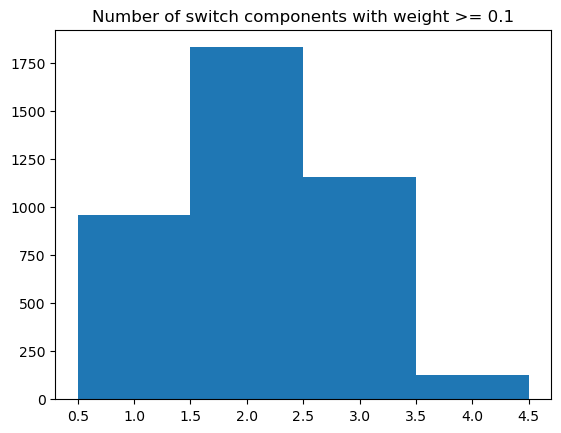

In [38]:
plt.hist(state_dist, bins = np.arange(0,n_switch_components)+0.5);
plt.title(f'Number of switch components with weight >= {threshold}');

In [39]:
post_tau = trace.posterior.tau.values
post_tau.shape

(25, 200, 30, 2)

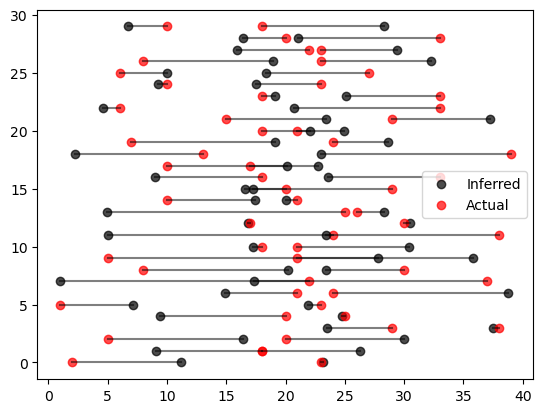

In [40]:
lines = []
post_mean_tau = np.mean(post_tau, axis = (0,1))
for this_trial, trial_dat in enumerate(post_mean_tau):
    for this_change, this_val in enumerate(trial_dat):
        l1 = plt.scatter(this_val, this_trial, color = 'k', alpha = 0.7, label = 'Inferred')
        l2 = plt.scatter(true_tau[this_trial, this_change], this_trial, color = 'r', alpha = 0.7, label = 'Actual')
        plt.plot([this_val, true_tau[this_trial][this_change]], [this_trial, this_trial], color = 'k', alpha = 0.5)
        lines.append([l1,l2])
plt.legend(lines[0], [l.get_label() for l in lines[0]])

In [41]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)

Sampling: [obs]


In [42]:
ppc_obs = ppc_trace['posterior_predictive']['obs'].values
mean_ppc_obs = ppc_obs.mean(axis=(0,1))

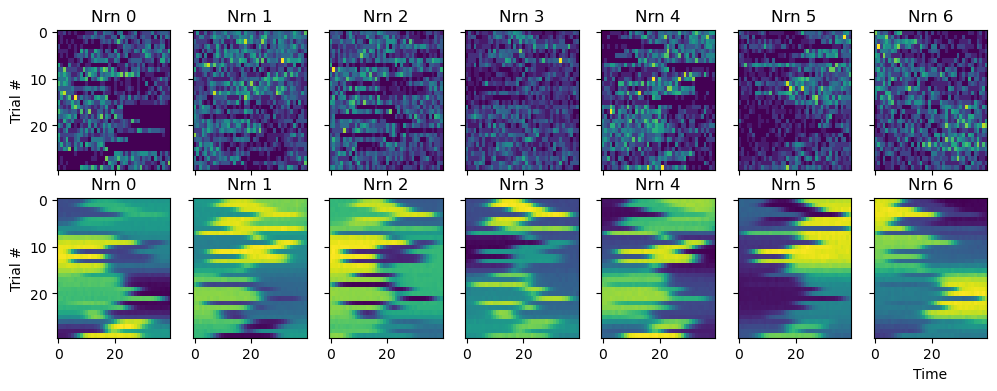

In [43]:
fig,ax = plt.subplots(2, 
                      spike_dat.shape[1], 
                      figsize = (12,4), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_dat,0,1), ax[0].flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(f'Nrn {ind}');
    if ind==0:
        this_ax.set_ylabel('Trial #');
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(mean_ppc_obs,0,1), ax[1].flatten())):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.set_title(f'Nrn {ind}');
    if ind==0:
        this_ax.set_ylabel('Trial #');
this_ax.set_xlabel('Time');

In [44]:
pearsonr(spike_dat.flatten(), mean_ppc_obs.flatten())

PearsonRResult(statistic=0.6376726049921355, pvalue=0.0)

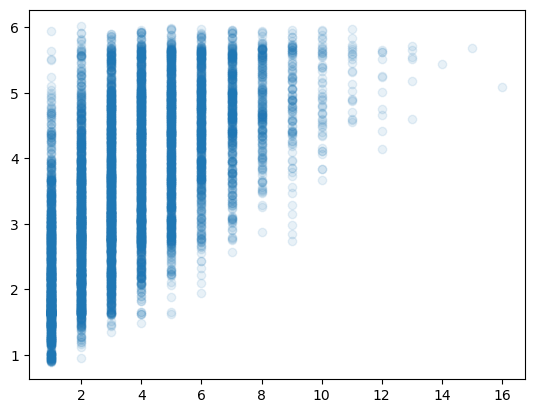

In [45]:
plt.scatter(spike_dat.flatten(), mean_ppc_obs.flatten(), alpha = 0.1);

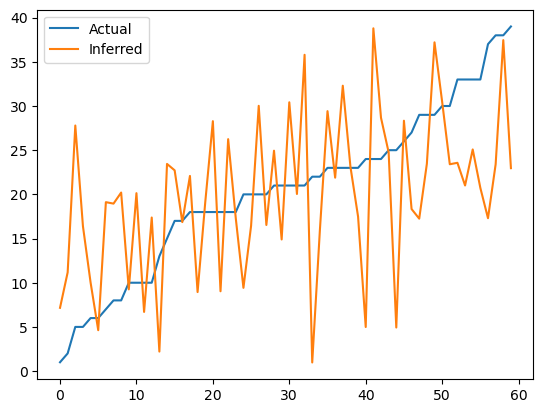

In [46]:
flat_true_tau = true_tau.flatten()
sort_inds = np.argsort(flat_true_tau)

flat_post_mean_tau = post_mean_tau.flatten()

plt.plot(flat_true_tau[sort_inds], label = 'Actual')
plt.plot(flat_post_mean_tau[sort_inds], label = 'Inferred')
plt.legend()

In [62]:
pearsonr(flat_true_tau, flat_post_mean_tau)

PearsonRResult(statistic=0.40922360757490234, pvalue=0.0011679779660997112)

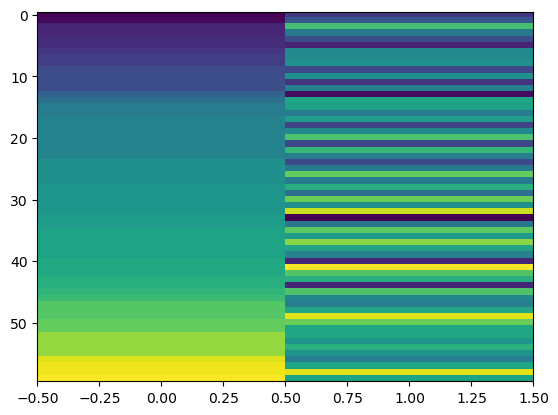

In [64]:
plt.imshow(np.vstack([flat_true_tau, flat_post_mean_tau]).T[sort_inds], aspect='auto')

# =====================================================

In [10]:
def return_bernoulli_mixture_data(
        length = 100,
        n_states = 3,
        n_neurons = 10,
        n_trials = 30,
        n_components = 2,
        mixture_probs = None,
        scaling = 1,
        ):
    """
    Returns data for the bernoulli mixture example

    Input:
        length: length of data
        n_states: number of states
        n_trials: number of trials
        n_components: number of mixutre components

    Output:
        true_lambda: true firing rate values
        data_vec: spike_array
        component_inds: indices of mixture components each trial is drawn from
        idx: time indices
    """
    if mixture_probs is None: 
        mixture_probs = np.random.random(n_components)
        mixture_probs /= np.sum(mixture_probs)
    else:
        assert len(mixture_probs) == n_components, "mixture_probs must be of length n_components" 
        assert np.sum(mixture_probs) == 1, "mixture_probs must sum to 1"

    idx = np.arange(length)

    # Generate transition times
    true_tau = np.cumsum(np.random.random((n_trials,n_states)),axis=-1)
    true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
    true_tau *= length
    true_tau = np.vectorize(int)(true_tau)

    # Generate state boundaries using transition times
    state_inds = np.concatenate([np.zeros((n_trials,1)),true_tau],axis=-1)
    state_inds = np.vectorize(int)(state_inds)
    true_tau = true_tau[:,:-1]

    # Generate emission values
    true_lambda = np.random.random((n_components,n_states,n_neurons))*scaling

    # Generate "trials" from n different mixture 
    # components with uneven mixture probabilities
    component_inds = np.random.choice(range(n_components), n_trials, p = mixture_probs)
    true_r = np.zeros((n_trials,length,n_neurons))
    for trial in range(n_trials):
        for state in range(n_states):
            for neuron in range(n_neurons):
                true_r[trial, state_inds[trial,state]:state_inds[trial,state+1], neuron] = \
                        true_lambda[component_inds[trial],state, neuron]

    # Final spiking data
    #data_vec = np.random.random(true_r.shape) < true_r
    data_vec = poisson.rvs(true_r)

    return true_r, data_vec, component_inds, idx, true_lambda, true_tau

In [11]:
true_r, data_vec, component_inds, idx, true_lambda, true_tau = \
                    return_bernoulli_mixture_data(
                            length = 40,
                            n_states = 3,
                            n_neurons = 7,
                            n_trials = 30,
                            n_components = 4,
                            mixture_probs = None,
                            scaling = 5,
                            )

In [49]:
spike_dat = np.swapaxes(data_vec, 1,2)
spike_dat = spike_dat[np.argsort(component_inds)]+1
component_inds = component_inds[np.argsort(component_inds)]

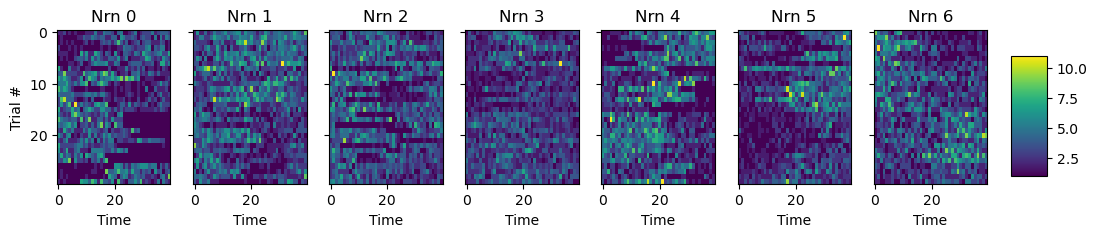

In [50]:

img_kwargs = dict(interpolation = 'nearest', aspect = 'auto')

fig,ax = plt.subplots(1, 
                      spike_dat.shape[1], 
                      figsize = (12,2), 
                      sharex=True, sharey=True
                     );
for ind, (this_dat, this_ax) in enumerate(zip(np.swapaxes(spike_dat,0,1), ax.flatten())):
    im = this_ax.imshow(this_dat, **img_kwargs)
    this_ax.set_title(f'Nrn {ind}');
    this_ax.set_xlabel('Time');
ax[0].set_ylabel('Trial #');
cax = fig.add_axes([0.92, 0.15, 0.03, 0.6])
cbar = fig.colorbar(im, cax=cax, )#label = '<-- Less Firing | More Firing -->')
#cbar.set_ticks([])